In [13]:
# import library
!pip install nltk
import nltk
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import re
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
import joblib

# import word tokenizer for tokenization process and stopwords for stop words process 
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords

# download APIs for natural language processing
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk

True

In [14]:
import warnings as wrn
wrn.filterwarnings('ignore')
# read data from CSV file
df = pd.read_csv('../data/raw/dataTotal.csv')
# df = pd.read_csv('marvelRanarok.csv', encoding="cp1252")

# convert label from text to digit process
positives = df[df["sentiment"] == "positive"] # group all the positive comments
negatives = df[df["sentiment"] == "negative"] # group all the negative comments
neutrals = df[df["sentiment"] == "neutral"]   # group all the neutral comments
negatives["sentiment"] = -1 # convert text label to digit lable -1 for negative
positives["sentiment"] = 1  # convert text label to digit lable 1 for positive
neutrals["sentiment"] = 0   # convert text label to digit lable 0 for neutral

# Combine pos, neg, neutral data into one DataFrame data using pd.concat()
data = pd.concat([positives,
                  neutrals,
                  negatives,
                 ],axis=0)

data.reset_index(inplace=True) # reset the index of each row

# Print some first data from the dataset after index reseting and ordering
data.head()


,index,review,sentiment
0,21,"Whoever made the Dr Strange casting, deserves ...",1
1,22,This is probably the Marvel movie I’m most hyp...,1
2,23,Dr. Strange is the coolest Marvel hero ever. B...,1
3,24,"This trailer is a masterpiece, a surprise too ...",1
4,25,Love when writers imagination goes wild in a g...,1


In [15]:
# Check number of negative, neutral and positive comments
# check total of comments that were collected
print(data["sentiment"].value_counts())
data.info()

sentiment
-1    341
 0    332
 1    330
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      1003 non-null   int64 
 1   review     1003 non-null   object
 2   sentiment  1003 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


In [16]:
# create pipeline for processing data

def preprocess_data(review):
    # Now we set our stop words to be the predefined for English
    stop_words = set(stopwords.words('english'))

    # Cleaning links: Remove all the links contained in text
    text = re.sub(r'http\S+', '', review)
    
    # Cleaning everything except alphabetic and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",review)
    
    # Tokenization
    token = word_tokenize(text)
    # tagged = pos_tag(token)
    # keep adjactive (JJ), adverb (RB) and verb (VB)
    # important_tokens = [w for w, pos in tagged if pos.startswith("JJ") or pos.startswith("RB") or pos.startswith("VB") or pos.startswith("NN")]

    # Now we manually remove all words from our tokenized text which are stop words...
    filtered_text = [] 
    for w in token:
        if w not in stop_words:
            filtered_text.append(w) # if the token is not a stop word, it will be appended into the list

    # the individual tokens in the list will be concatenated together into a single string using join()
    # these tokens is sepated by a space " "
    preprocessed_text = " ".join(filtered_text)
    return preprocessed_text

# Create an iteration for processing each comment in dataset and store the processed text into the list preprocessed_text[]
preprocessed_text = [preprocess_data(text) for text in data["review"]]
print(preprocessed_text)


['Whoever made Dr Strange casting deserves Oscar', 'This probably Marvel movie I hyped Phase 4 teaser disappoint Bring Sinister Strange villain Scarlet Witch Shuma Gorath Gargantos potentially X Men Fantastic Four Deadpool Bring Madness', 'Dr Strange coolest Marvel hero ever Benedict fits perfectly smart sensible character', 'This trailer masterpiece surprise huge magnificent Dr Strange always got captivating aura', 'Love writers imagination goes wild good fantasy way degrading depth characters', 'It crazy 13 years MCU still going strong ever WandaVision broke even barriers might best film yet Sam Raimi bringing A Game since first superhero film since Spider Man 3 Based talks movie insiders say going visually exceptional VFX going mind blowing Hopefully wins MCU first Oscar editing visual effects', 'Doctor Strange Sam Raimi Possibly chilling marvel movie yet', 'Marvel Unstoppable point They making one masterpiece another So Hyped one', 'Just saw movie last night I LOVED could little lo

In [17]:
for i in range(0,5):
    print(preprocessed_text[i],end="\n")

Whoever made Dr Strange casting deserves Oscar
This probably Marvel movie I hyped Phase 4 teaser disappoint Bring Sinister Strange villain Scarlet Witch Shuma Gorath Gargantos potentially X Men Fantastic Four Deadpool Bring Madness
Dr Strange coolest Marvel hero ever Benedict fits perfectly smart sensible character
This trailer masterpiece surprise huge magnificent Dr Strange always got captivating aura
Love writers imagination goes wild good fantasy way degrading depth characters


In [18]:
# vectorization
# convert text to vector for SVM
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_text) 
y = np.asarray(data["sentiment"]) # label
# print(vectorizer.get_feature_names_out())
# print(X)
print(y)

[ 1  1  1 ... -1 -1 -1]


In [19]:
# split train data and test data 20% testing and 80% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM model
# model = SVC(kernel="linear").fit(X_train, y_train)
model = SVC(decision_function_shape='ovo').fit(X_train, y_train)

# Test model and create a report matrix for this model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(X_train.shape)
print(X_train)


              precision    recall  f1-score   support

          -1       0.81      0.72      0.76        72
           0       0.59      0.68      0.63        63
           1       0.77      0.74      0.75        66

    accuracy                           0.72       201
   macro avg       0.72      0.72      0.72       201
weighted avg       0.73      0.72      0.72       201

(802, 2912)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8975 stored elements and shape (802, 2912)>
  Coords	Values
  (0, 54)	0.3136499631053679
  (0, 138)	0.20188597437776998
  (0, 147)	0.3004062109623138
  (0, 390)	0.23116439802239272
  (0, 517)	0.25822378631382287
  (0, 1079)	0.23955776604820053
  (0, 1127)	0.24273392673775449
  (0, 1435)	0.3136499631053679
  (0, 1555)	0.20188597437776998
  (0, 1588)	0.3323159833709902
  (0, 2476)	0.3323159833709902
  (0, 2531)	0.1364042970245631
  (0, 2620)	0.3323159833709902
  (0, 2757)	0.21249837775677038
  (1, 1481)	0.9676056256455985
  (1, 1676)	0.25246

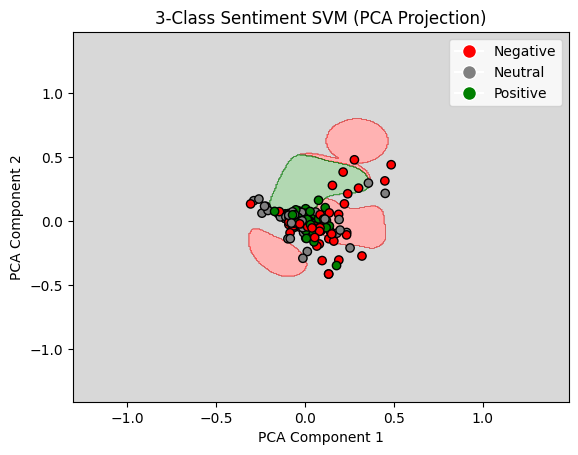

In [20]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

#TF-IDF is sparse → convert to dense
X_dense = X_train.toarray()
X_dense_T = X_test.toarray()
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_dense)
X_2d_T = pca.fit_transform(X_dense_T)

#Train SVM on 2D Projection
clf_2d = SVC()
clf_2d.fit(X_2d, y_train)

#Plot Decision Regions
xx, yy = np.meshgrid(
    np.linspace(X_2d_T[:,0].min()-1, X_2d_T[:,0].max()+1, 400),
    np.linspace(X_2d_T[:,1].min()-1, X_2d_T[:,1].max()+1, 400)
)

Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cmap = ListedColormap(['red', 'gray', 'green'])

plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
plt.scatter(X_2d_T[:,0], X_2d_T[:,1], c=y_test, cmap=cmap, edgecolors='k')

plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Negative',
               markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Neutral',
               markerfacecolor='gray', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Positive',
               markerfacecolor='green', markersize=10)
])

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("3-Class Sentiment SVM (PCA Projection)")
plt.show()

In [21]:
# save the model
# store the trained model
joblib.dump(model, "../model/svm_sentiment_model.pkl")

# Save the vectorizer (important for preprocessing new text consistently)
# joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['../model/svm_sentiment_model.pkl']

In [22]:
#load the trained model
load_model = joblib.load("../model/svm_sentiment_model.pkl")

# Predict sentiment and test model
reviews = []
reviews.append("this seem to be ok, not so intersting")
reviews.append("no comment - stupid movie, acting average or worse... screenplay - no sense at all... SKIP IT!")
reviews.append("I don't care if some people voted this movie to be bad. If you want the Truth this is a Very Good Movie! It has every thing a movie should have. You really should Get this one")
reviews.append("Worst horror film ever but funniest film ever rolled in one you have got to see this film it is so cheap it is unbeliaveble but you have to see it really!!!! P.s watch the carrot")

for new_review in reviews:
    print(new_review)
    new_processed = preprocess_data(new_review)
    X_new = vectorizer.transform([new_processed])
    result = load_model.predict(X_new) # -1 = negative, 1 = positive, 0 = neutral
    if result == 1:
        print("Positive")
    elif result == 0:
        print("Neural")
    else:
        print("Negative")

this seem to be ok, not so intersting
Neural
no comment - stupid movie, acting average or worse... screenplay - no sense at all... SKIP IT!
Negative
I don't care if some people voted this movie to be bad. If you want the Truth this is a Very Good Movie! It has every thing a movie should have. You really should Get this one
Positive
Worst horror film ever but funniest film ever rolled in one you have got to see this film it is so cheap it is unbeliaveble but you have to see it really!!!! P.s watch the carrot
Positive
